In [35]:
import soundfile as sf
from IPython.display import Audio
import numpy as np
import random 
import pandas as pd
import os
from os.path import join as pjoin
import tqdm
from acoustics.bands import third
import scipy.signal as sig
from IPython.display import Audio
# from masp import shoebox_room_sim as srs
from scipy.io import wavfile
#import mat73
import matplotlib.pyplot as plt
import torch

In [36]:
# import my modules:
import sys
sys.path.append('../src')
import joa_helpers as hlp
import cond_waveunet_dataset as dset
import cond_waveunet_model as cwaveunet
from cond_waveunet_traintest import infer_and_compute_loss
import importlib
importlib.reload(hlp)
importlib.reload(dset)
importlib.reload(cwaveunet)

<module 'cond_waveunet_model' from '/home/ubuntu/joanna/reverb-match-cond-u-net/notebooks/../src/cond_waveunet_model.py'>

### Inspect datapoints:

In [37]:
# load arguments used for training
args=torch.load("../results/args.pt")
# instantiate a test data set 
args.split="test"
dataset=dset.DatasetReverbTransfer(args)
# get one data sample 
sContent_in, sStyle_in, sTarget_out = dataset[3]

In [38]:
# playback for the data sample
audios=[sContent_in, sStyle_in, sTarget_out]
names=["sContent_in", "sStyle_in", "sTarget_out"]

for i,audio in enumerate(audios):
    print(names[i])
    audio=audio.squeeze(0).cpu()
    display(Audio(audio,rate=48e3))


sContent_in


sStyle_in


sTarget_out


### Inspect inference with trained models:

In [58]:
# load reverb encoder
model_ReverbEncoder=cwaveunet.ReverbEncoder(args)
model_ReverbEncoder.to("cuda")
model_ReverbEncoder.eval()
# check waveunet 
model_waveunet=cwaveunet.waveunet(args)
model_waveunet.to("cuda")
model_waveunet.eval()

# load training results
train_results=torch.load(args.savedir + "13-11-2023--12-37.pt",map_location=args.device)
model_waveunet.load_state_dict(train_results["model_waveunet_state_dict"])
model_ReverbEncoder.load_state_dict(train_results["model_reverbenc_state_dict"])


<All keys matched successfully>

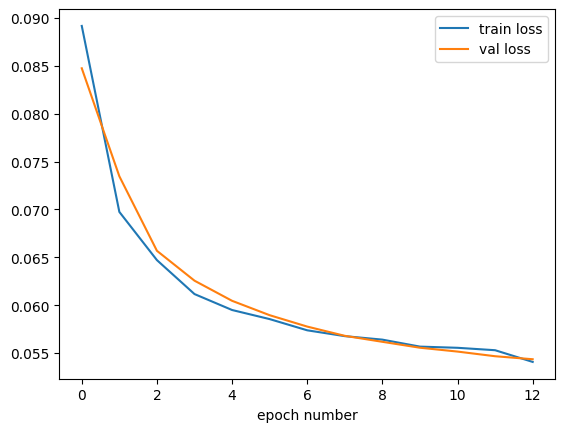

In [59]:
# load and plot the loss evolution 
loss = list(zip(*train_results['loss']))
plt.figure()
plt.plot(loss[1],label="train loss")
plt.plot(loss[0],label="val loss")
plt.xlabel("epoch number")
plt.legend()
plt.show()

In [66]:
def infer_and_compute_loss(model_reverbenc, model_waveunet, data, device):
    with torch.no_grad():
        # Function to infer target audio
        # ------------------------------
        # get datapoint
        sContent_in = data[0].to(device)
        sStyle_in=data[1].to(device)
        sTarget_gt=data[2].to(device)
        # forward pass - get prediction of the ir
        embedding_gt=model_reverbenc(sStyle_in.unsqueeze(0))
        sTarget_prediction=model_waveunet(sContent_in.unsqueeze(0),embedding_gt)
        return sContent_in, sStyle_in, sTarget_gt, sTarget_prediction

sContent_in, sStyle_in, sTarget_gt, sTarget_prediction=infer_and_compute_loss(model_ReverbEncoder, model_waveunet, dataset[100], args.device)

In [67]:
# playback for the data sample
audios=[sContent_in, sStyle_in, sTarget_gt, sTarget_prediction]
names=["sContent_in", "sStyle_in", "sTarget_gt", "sTarget_prediction"]

for i,audio in enumerate(audios):
    print(names[i])
    audio=audio.squeeze(0).cpu()
    display(Audio(audio,rate=48e3))

sContent_in


sStyle_in


sTarget_gt


sTarget_prediction
